In [1]:
#!pip install pyshp #pip install pyproj
#!pip install basemap
#!pip3 install cartopy
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pdb
import scipy.spatial.qhull as qhull
from scipy.interpolate import griddata
import pyproj
#import pyshp
from u_interpolate_small import regrid_irregular_quick
from datetime import date
from ndays import numOfDays
import glob
import calendar
import pandas as pd
import xarray as xr
#import cartopy.crs as ccrs
#import cartopy.feature as cf

In [2]:
# Define domain and time period
start_lat = 6 # -30 #37
end_lat = 12 # -17
start_lon = -4 # 15 # -4#15#-18
end_lon = 4 #30
start_year = '2010'
start_month = '07'#12'#12'
end_year = '2010'
end_month = '07'#12'#12'
start_day = '01'
end_day = '31'

In [3]:
# find core indices using one file
core_filename = '/prj/Africa_cloud/ch9_wavelet/2010/09/201009081045.nc'
core_data = nc.Dataset(core_filename,'r')
# read in cores lat/lon
lat_temp = np.array(core_data.variables['lat'][:])
lon_temp = np.array(core_data.variables['lon'][:])
#lon_filter = lon >-181 # acceptable values
#lon_fl = lon[lon_filter] #filtered long
lat_ind = np.where((lat_temp>=start_lat) & (lat_temp<=end_lat))[0]
lon_ind = np.where((lon_temp>= start_lon) & (lon_temp<=end_lon))[0]
lat = lat_temp[lat_ind[0]:lat_ind[-1]+1]
lon = lon_temp[lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
X, Y = np.meshgrid(lon,lat)

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1
#time = 
cores = np.zeros((len(lat),len(lon),t*24),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((len(lat),len(lon),t*24),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*24)) #using every fourth value for hourly comparison- 24hr
#time = np.zeros((len(lat)-1,len(lon)-1,t*96))

In [4]:
# find precip indices using one file
precip_filename = '/prj/global_water/MCS_Feng/global_v2/2d_fields/20100101.0000_20110101.0000/mcstrack_20100901_0630.nc'
precip_data = nc.Dataset(precip_filename,'r')
lat_p_temp = np.array(precip_data.variables['latitude'][:])
lon_p_temp = np.array(precip_data.variables['longitude'][:])
lat_ind_p = np.where((lat_p_temp[:,0]>=start_lat) & (lat_p_temp[:,0]<=end_lat))[0]
lon_ind_p = np.where((lon_p_temp[0,:]>= start_lon) & (lon_p_temp[0,:]<=end_lon))[0]
lat_p = lat_p_temp[lat_ind_p[0]:lat_ind_p[-1]+1,lon_ind_p[0]:lon_ind_p[-1]+1]
lon_p = lon_p_temp[lat_ind_p[0]:lat_ind_p[-1]+1,lon_ind_p[0]:lon_ind_p[-1]+1]
#X_p, Y_p = np.meshgrid(lon_p,lat_p)

In [5]:
# read in precip data 
list_of_file_names_precip=[]

if int(start_year)==int(end_year): 
    dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+start_year+'0101.0000_'+str(int(start_year)+1)+'0101.0000'
    os.chdir(dir_name_precip)
    for m in range(int(start_month),int(end_month)+1,1):
            if m<10:
                month = str(m).zfill(2)
            else:
                month = str(m)   
            all_files=sorted(glob.glob("mcstrack_"+start_year+month+"*.nc"));
            #print(all_files)
            list_of_file_names_precip.append(all_files) # all days in month
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+str(i)+'0101.0000_'+str(i+1)+'0101.0000/'
        #os.chdir(dir_name_precip)
        if y==1:
            for m in range(int(start_month),12+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                list_of_file_names_precip.append(sorted(glob.glob(dir_name_precip+'mcstrack_'+str(i)+month+'*.nc'))) # day 1
                y=y+1            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m) 
                dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+str(i)+'0101.0000_'+str(i+1)+'0101.0000/'
                list_of_file_names_precip.append(sorted(glob.glob(dir_name_precip+'mcstrack_'+str(i)+month+'*.nc'))) # day 1
                    
    
    #print(dir_name_precip)
list_of_files_precip=[]                
for a in range(0,len(list_of_file_names_precip),1):
    list_of_files_precip = list_of_files_precip+list_of_file_names_precip[a]

In [6]:
# preallocate
precip = np.zeros((len(lat_p[:,1]),len(lon_p[1,:]),t*24),dtype=float)
regidded_precip = np.zeros((len(lat),len(lon),t*24),dtype=float)
regidded_precip_test = np.zeros((len(lat),len(lon),t*24),dtype=float)
time_IMERG = np.zeros(t*24)

for l in range(0,len(list_of_files_precip),1):#22,31,1):#
    precip_filename = list_of_files_precip[l]
    print(precip_filename)
    print(l)
    precip_data = nc.Dataset(precip_filename,'r')
    precip_temp = np.array(precip_data.variables['precipitation'])[0,lat_ind_p[0]:lat_ind_p[-1]+1,lon_ind_p[0]:lon_ind_p[-1]+1]
    precip[:,:,l] = precip_temp  
    time_IMERG[l]= str(precip_filename[-16:-3])
    A = regrid_irregular_quick(lon_p[1,:],lat_p[:,1],lon,lat,precip_temp)
    #B = regrid_irregular_quick(lat_p[:,1],lon_p[1,:],lat,lon,precip_temp)
    regidded_precip[:,:,l] = A   
    #regidded_precip_test[:,:,l] = np.transpose(B)   


mcstrack_20100701_0030.nc
0
mcstrack_20100701_0130.nc
1
mcstrack_20100701_0230.nc
2
mcstrack_20100701_0330.nc
3
mcstrack_20100701_0430.nc
4
mcstrack_20100701_0530.nc
5
mcstrack_20100701_0630.nc
6
mcstrack_20100701_0730.nc
7
mcstrack_20100701_0830.nc
8
mcstrack_20100701_0930.nc
9
mcstrack_20100701_1030.nc
10
mcstrack_20100701_1130.nc
11
mcstrack_20100701_1230.nc
12
mcstrack_20100701_1330.nc
13
mcstrack_20100701_1430.nc
14
mcstrack_20100701_1530.nc
15
mcstrack_20100701_1630.nc
16
mcstrack_20100701_1730.nc
17
mcstrack_20100701_1830.nc
18
mcstrack_20100701_1930.nc
19
mcstrack_20100701_2030.nc
20
mcstrack_20100701_2130.nc
21
mcstrack_20100701_2230.nc
22
mcstrack_20100701_2330.nc
23
mcstrack_20100702_0030.nc
24
mcstrack_20100702_0130.nc
25
mcstrack_20100702_0230.nc
26
mcstrack_20100702_0330.nc
27
mcstrack_20100702_0430.nc
28
mcstrack_20100702_0530.nc
29
mcstrack_20100702_0630.nc
30
mcstrack_20100702_0730.nc
31
mcstrack_20100702_0830.nc
32
mcstrack_20100702_0930.nc
33
mcstrack_20100702_1030.n

mcstrack_20100712_1330.nc
277
mcstrack_20100712_1430.nc
278
mcstrack_20100712_1530.nc
279
mcstrack_20100712_1630.nc
280
mcstrack_20100712_1730.nc
281
mcstrack_20100712_1830.nc
282
mcstrack_20100712_1930.nc
283
mcstrack_20100712_2030.nc
284
mcstrack_20100712_2130.nc
285
mcstrack_20100712_2230.nc
286
mcstrack_20100712_2330.nc
287
mcstrack_20100713_0030.nc
288
mcstrack_20100713_0130.nc
289
mcstrack_20100713_0230.nc
290
mcstrack_20100713_0330.nc
291
mcstrack_20100713_0430.nc
292
mcstrack_20100713_0530.nc
293
mcstrack_20100713_0630.nc
294
mcstrack_20100713_0730.nc
295
mcstrack_20100713_0830.nc
296
mcstrack_20100713_0930.nc
297
mcstrack_20100713_1030.nc
298
mcstrack_20100713_1130.nc
299
mcstrack_20100713_1230.nc
300
mcstrack_20100713_1330.nc
301
mcstrack_20100713_1430.nc
302
mcstrack_20100713_1530.nc
303
mcstrack_20100713_1630.nc
304
mcstrack_20100713_1730.nc
305
mcstrack_20100713_1830.nc
306
mcstrack_20100713_1930.nc
307
mcstrack_20100713_2030.nc
308
mcstrack_20100713_2130.nc
309
mcstrack_2

mcstrack_20100724_0030.nc
552
mcstrack_20100724_0130.nc
553
mcstrack_20100724_0230.nc
554
mcstrack_20100724_0330.nc
555
mcstrack_20100724_0430.nc
556
mcstrack_20100724_0530.nc
557
mcstrack_20100724_0630.nc
558
mcstrack_20100724_0730.nc
559
mcstrack_20100724_0830.nc
560
mcstrack_20100724_0930.nc
561
mcstrack_20100724_1030.nc
562
mcstrack_20100724_1130.nc
563
mcstrack_20100724_1230.nc
564
mcstrack_20100724_1330.nc
565
mcstrack_20100724_1430.nc
566
mcstrack_20100724_1530.nc
567
mcstrack_20100724_1630.nc
568
mcstrack_20100724_1730.nc
569
mcstrack_20100724_1830.nc
570
mcstrack_20100724_1930.nc
571
mcstrack_20100724_2030.nc
572
mcstrack_20100724_2130.nc
573
mcstrack_20100724_2230.nc
574
mcstrack_20100724_2330.nc
575
mcstrack_20100725_0030.nc
576
mcstrack_20100725_0130.nc
577
mcstrack_20100725_0230.nc
578
mcstrack_20100725_0330.nc
579
mcstrack_20100725_0430.nc
580
mcstrack_20100725_0530.nc
581
mcstrack_20100725_0630.nc
582
mcstrack_20100725_0730.nc
583
mcstrack_20100725_0830.nc
584
mcstrack_2

In [7]:
# read in cores data
list_of_file_names = []

for i in range(0,len(time_IMERG),1):
    current_file = str(time_IMERG[i])#+'.nc'
    SY= current_file[0:4]
    MM= current_file[4:6]
    #DD= current_file[7:8]
    #HR= current_file[9:10]
    #MIN= current_file[11:12]
    all_file_names = '/prj/Africa_cloud/ch9_wavelet/'+SY+'/'+MM+'/'+current_file[0:-2]+'.nc' 
    #print(all_file_names)
    if os.path.isfile(all_file_names):      
    #all_file_names= dir_name+ #sorted(glob.glob(dir_name+start_year+month+"*30.nc"));
        list_of_file_names.append(all_file_names) # all days in month
    else:
        list_of_file_names.append('file_not_available') # all days in month
            
 
#print(list_of_file_names)

In [8]:
#counter = 0
for l in range(0,len(list_of_file_names),1):#2, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_file_names[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    if os.path.isfile(all_file_names):      
        core_data = nc.Dataset(core_filename,'r')
        print(l)
        cores_temp = np.array(core_data.variables['cores'])[0,lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
        cores[:,:,l] = cores_temp   
        tir_temp = np.array(core_data.variables['tir'])[0,lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
        tir[:,:,l] = tir_temp   
#    df['Column Name'] = pd.to_datetime(df['Column Name'])
        time_core[l] = (core_filename[-15:-3])
        core_data.close()  
    else:
        cores[:,:,l] = cores_temp*np.nan  
        tir[:,:,l] = tir_temp*np.nan   
        time_core[l] = (core_filename[-15:-3])
  

/prj/Africa_cloud/ch9_wavelet/2010/07/201007010030.nc
0
/prj/Africa_cloud/ch9_wavelet/2010/07/201007010130.nc
1
/prj/Africa_cloud/ch9_wavelet/2010/07/201007010230.nc
2
/prj/Africa_cloud/ch9_wavelet/2010/07/201007010330.nc
3
/prj/Africa_cloud/ch9_wavelet/2010/07/201007010430.nc
4
/prj/Africa_cloud/ch9_wavelet/2010/07/201007010530.nc
5
/prj/Africa_cloud/ch9_wavelet/2010/07/201007010630.nc
6
/prj/Africa_cloud/ch9_wavelet/2010/07/201007010730.nc
7
/prj/Africa_cloud/ch9_wavelet/2010/07/201007010830.nc
8
/prj/Africa_cloud/ch9_wavelet/2010/07/201007010930.nc
9
/prj/Africa_cloud/ch9_wavelet/2010/07/201007011030.nc
10
/prj/Africa_cloud/ch9_wavelet/2010/07/201007011130.nc
11
/prj/Africa_cloud/ch9_wavelet/2010/07/201007011230.nc
12
/prj/Africa_cloud/ch9_wavelet/2010/07/201007011330.nc
13
/prj/Africa_cloud/ch9_wavelet/2010/07/201007011430.nc
14
/prj/Africa_cloud/ch9_wavelet/2010/07/201007011530.nc
15
/prj/Africa_cloud/ch9_wavelet/2010/07/201007011630.nc
16
/prj/Africa_cloud/ch9_wavelet/2010/07/201

144
/prj/Africa_cloud/ch9_wavelet/2010/07/201007070130.nc
145
/prj/Africa_cloud/ch9_wavelet/2010/07/201007070230.nc
146
/prj/Africa_cloud/ch9_wavelet/2010/07/201007070330.nc
147
/prj/Africa_cloud/ch9_wavelet/2010/07/201007070430.nc
148
/prj/Africa_cloud/ch9_wavelet/2010/07/201007070530.nc
149
/prj/Africa_cloud/ch9_wavelet/2010/07/201007070630.nc
150
/prj/Africa_cloud/ch9_wavelet/2010/07/201007070730.nc
151
/prj/Africa_cloud/ch9_wavelet/2010/07/201007070830.nc
152
/prj/Africa_cloud/ch9_wavelet/2010/07/201007070930.nc
153
/prj/Africa_cloud/ch9_wavelet/2010/07/201007071030.nc
154
/prj/Africa_cloud/ch9_wavelet/2010/07/201007071130.nc
155
/prj/Africa_cloud/ch9_wavelet/2010/07/201007071230.nc
156
/prj/Africa_cloud/ch9_wavelet/2010/07/201007071330.nc
157
/prj/Africa_cloud/ch9_wavelet/2010/07/201007071430.nc
158
/prj/Africa_cloud/ch9_wavelet/2010/07/201007071530.nc
159
/prj/Africa_cloud/ch9_wavelet/2010/07/201007071630.nc
160
/prj/Africa_cloud/ch9_wavelet/2010/07/201007071730.nc
161
/prj/Afric

/prj/Africa_cloud/ch9_wavelet/2010/07/201007130030.nc
288
/prj/Africa_cloud/ch9_wavelet/2010/07/201007130130.nc
289
/prj/Africa_cloud/ch9_wavelet/2010/07/201007130230.nc
290
/prj/Africa_cloud/ch9_wavelet/2010/07/201007130330.nc
291
/prj/Africa_cloud/ch9_wavelet/2010/07/201007130430.nc
292
/prj/Africa_cloud/ch9_wavelet/2010/07/201007130530.nc
293
/prj/Africa_cloud/ch9_wavelet/2010/07/201007130630.nc
294
/prj/Africa_cloud/ch9_wavelet/2010/07/201007130730.nc
295
/prj/Africa_cloud/ch9_wavelet/2010/07/201007130830.nc
296
/prj/Africa_cloud/ch9_wavelet/2010/07/201007130930.nc
297
/prj/Africa_cloud/ch9_wavelet/2010/07/201007131030.nc
298
/prj/Africa_cloud/ch9_wavelet/2010/07/201007131130.nc
299
/prj/Africa_cloud/ch9_wavelet/2010/07/201007131230.nc
300
/prj/Africa_cloud/ch9_wavelet/2010/07/201007131330.nc
301
/prj/Africa_cloud/ch9_wavelet/2010/07/201007131430.nc
302
/prj/Africa_cloud/ch9_wavelet/2010/07/201007131530.nc
303
/prj/Africa_cloud/ch9_wavelet/2010/07/201007131630.nc
304
/prj/Africa_cl

/prj/Africa_cloud/ch9_wavelet/2010/07/201007182230.nc
430
/prj/Africa_cloud/ch9_wavelet/2010/07/201007182330.nc
431
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190030.nc
432
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190130.nc
433
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190230.nc
434
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190330.nc
435
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190430.nc
436
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190530.nc
437
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190630.nc
438
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190730.nc
439
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190830.nc
440
/prj/Africa_cloud/ch9_wavelet/2010/07/201007190930.nc
441
/prj/Africa_cloud/ch9_wavelet/2010/07/201007191030.nc
442
/prj/Africa_cloud/ch9_wavelet/2010/07/201007191130.nc
443
/prj/Africa_cloud/ch9_wavelet/2010/07/201007191230.nc
444
/prj/Africa_cloud/ch9_wavelet/2010/07/201007191330.nc
445
/prj/Africa_cloud/ch9_wavelet/2010/07/201007191430.nc
446
/prj/Africa_cl

572
/prj/Africa_cloud/ch9_wavelet/2010/07/201007242130.nc
573
/prj/Africa_cloud/ch9_wavelet/2010/07/201007242230.nc
574
/prj/Africa_cloud/ch9_wavelet/2010/07/201007242330.nc
575
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250030.nc
576
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250130.nc
577
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250230.nc
578
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250330.nc
579
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250430.nc
580
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250530.nc
581
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250630.nc
582
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250730.nc
583
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250830.nc
584
/prj/Africa_cloud/ch9_wavelet/2010/07/201007250930.nc
585
/prj/Africa_cloud/ch9_wavelet/2010/07/201007251030.nc
586
/prj/Africa_cloud/ch9_wavelet/2010/07/201007251130.nc
587
/prj/Africa_cloud/ch9_wavelet/2010/07/201007251230.nc
588
/prj/Africa_cloud/ch9_wavelet/2010/07/201007251330.nc
589
/prj/Afric

715
/prj/Africa_cloud/ch9_wavelet/2010/07/201007302030.nc
716
/prj/Africa_cloud/ch9_wavelet/2010/07/201007302130.nc
717
/prj/Africa_cloud/ch9_wavelet/2010/07/201007302230.nc
718
/prj/Africa_cloud/ch9_wavelet/2010/07/201007302330.nc
719
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310030.nc
720
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310130.nc
721
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310230.nc
722
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310330.nc
723
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310430.nc
724
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310530.nc
725
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310630.nc
726
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310730.nc
727
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310830.nc
728
/prj/Africa_cloud/ch9_wavelet/2010/07/201007310930.nc
729
/prj/Africa_cloud/ch9_wavelet/2010/07/201007311030.nc
730
/prj/Africa_cloud/ch9_wavelet/2010/07/201007311130.nc
731
/prj/Africa_cloud/ch9_wavelet/2010/07/201007311230.nc
732
/prj/Afric

In [9]:
print(cores.shape)
print(precip.shape)
print(regidded_precip.shape)

(214, 229, 744)
(60, 80, 744)
(214, 229, 744)


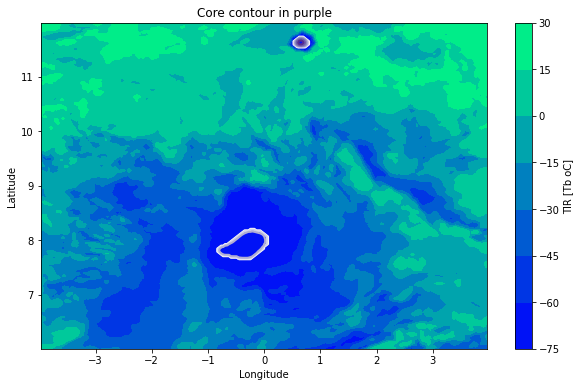

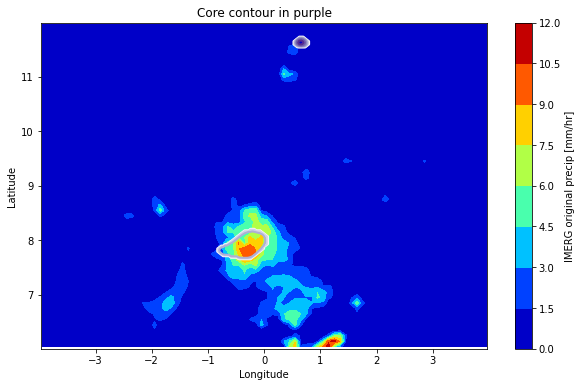

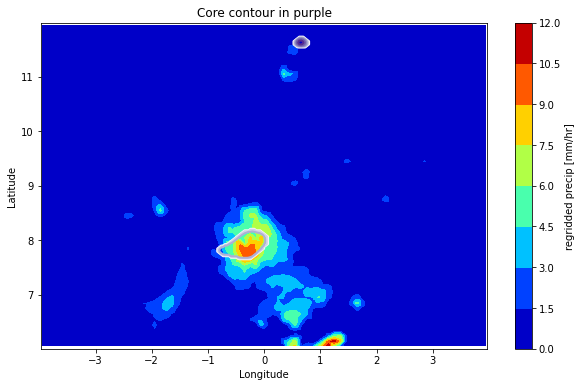

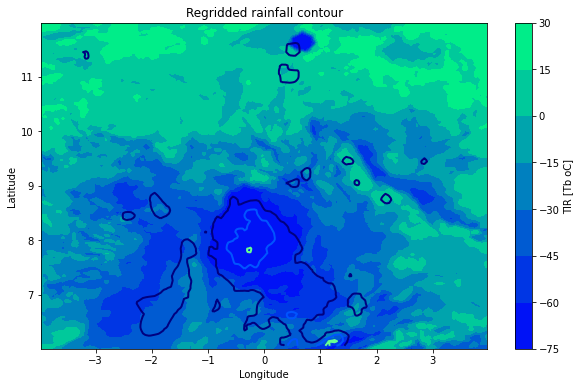

In [40]:
# visualize core data at inherent grid/resol
day = 24*1
plt.figure(figsize=(10,6))
plt.contour(X,Y,cores[:,:,day],cmap='Purples',linewidths=2)
plt.contourf(X,Y,tir[:,:,day],cmap='winter')
#plt.clim([-80, 80])
plt.colorbar(label='TIR [Tb oC]')#plt.contour(X,Y,cores[:,:,22],color='red')
#plt.colorbar(label='power')
#ax = plt.axes(projection = ccrs.Mercator())
# This will add borders
#ax.add_feature(cf.BORDERS)
plt.title('Core contour in purple')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([X[0,0],X[0,-1]])
plt.ylim([Y[0,0],Y[-1,0]])
plt.show()

# visualize core data at inherent grid/resol
plt.figure(figsize=(10,6))
plt.contour(X,Y,cores[:,:,day],cmap='Purples',linewidths=2)
plt.contourf(lon_p,lat_p,precip[:,:,day],cmap='jet')#
plt.colorbar(label='IMERG original precip [mm/hr]')
plt.title('Core contour in purple')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([X[0,0],X[0,-1]])
plt.ylim([Y[0,0],Y[-1,0]])
plt.show()

# visualize core data at inherent grid/resol
plt.figure(figsize=(10,6))
plt.contour(X,Y,cores[:,:,day],cmap='Purples',linewidths=2)
plt.contourf(X,Y,regidded_precip[:,:,day],cmap='jet') #regidded_precip
plt.colorbar(label='regridded precip [mm/hr]')
plt.title('Core contour in purple')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([X[0,0],X[0,-1]])
plt.ylim([Y[0,0],Y[-1,0]])
plt.show()

# visualize tir and imerg data 
plt.figure(figsize=(10,6))
plt.contour(X,Y,regidded_precip[:,:,day],levels=[1, 5, 10, 15, 20],cmap='jet',linewidths=2) #regidded_precip
plt.contourf(X,Y,tir[:,:,day],cmap='winter')
plt.colorbar(label='TIR [Tb oC]')#plt.contour(X,Y,cores[:,:,22],color='red')
plt.title('Regridded rainfall contour')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([X[0,0],X[0,-1]])
plt.ylim([Y[0,0],Y[-1,0]])
plt.show()

In [11]:
# find rainfall pixels collocated with cores
cores_1D = cores.flatten()
precip_1D = regidded_precip.flatten() # cores and precip have same size and indexing - obs in connis notebook
cores_ind_gt_0 = np.where(cores_1D>0)[0]
precip_collocated_w_cores = precip_1D[cores_ind_gt_0] #dat in connis notebook

cores_ind_gt_0
print(precip_collocated_w_cores.shape)
print(np.nanmax(precip_collocated_w_cores))

(97423,)
75.4496817001363


In [12]:
print(np.nanmax(precip_1D))

75.4496817001363


In [13]:
# calculate frequency of rainfall above a threshold 
# dat = 
# threshold = 30mm/hr

def calc_treshReached(dat, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat))

In [14]:
# calculate frequency of rainfall above a threshold relative to the same frequency for the full rainfall field (native)

def calc_treshReached_vsObs(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat)) / np.sum(np.array(obs)>thresh)/np.sum(np.isfinite(obs))

In [15]:
# calculate fraction of caught rainfall pixels above a threshold
# calc_treshMissed in connis script

def calc_treshcaught(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [16]:
# calculate frequency of rainfall above a threshold for regions with wavelet power above a given percentile

def percentile(dat, wav, thresh, perc):
    pval = np.percentile(wav, perc)
    dats = np.array(dat)[np.array(wav)>=pval]
    return np.sum(dats>thresh)/np.sum(np.isfinite(dats))

In [17]:
# fraction of pixels where threshold exceeded
# dat = precip_collocated_w_cores
# obs = precip_1D
thresh = 20
# treached = calc_treshReached(precip_collocated_w_cores,thresh)
# print(treached)

In [18]:
# fraction of caught pixels
# tcaught = calc_treshcaught(precip_collocated_w_cores,precip_1D, thresh)
# print(tcaught)

In [19]:
# fraction of threshold reached in dat vs threshold reached in obs
tfrac = calc_treshReached_vsObs(precip_collocated_w_cores,precip_1D, thresh)
print(tfrac)

4.9840621654495566e-14


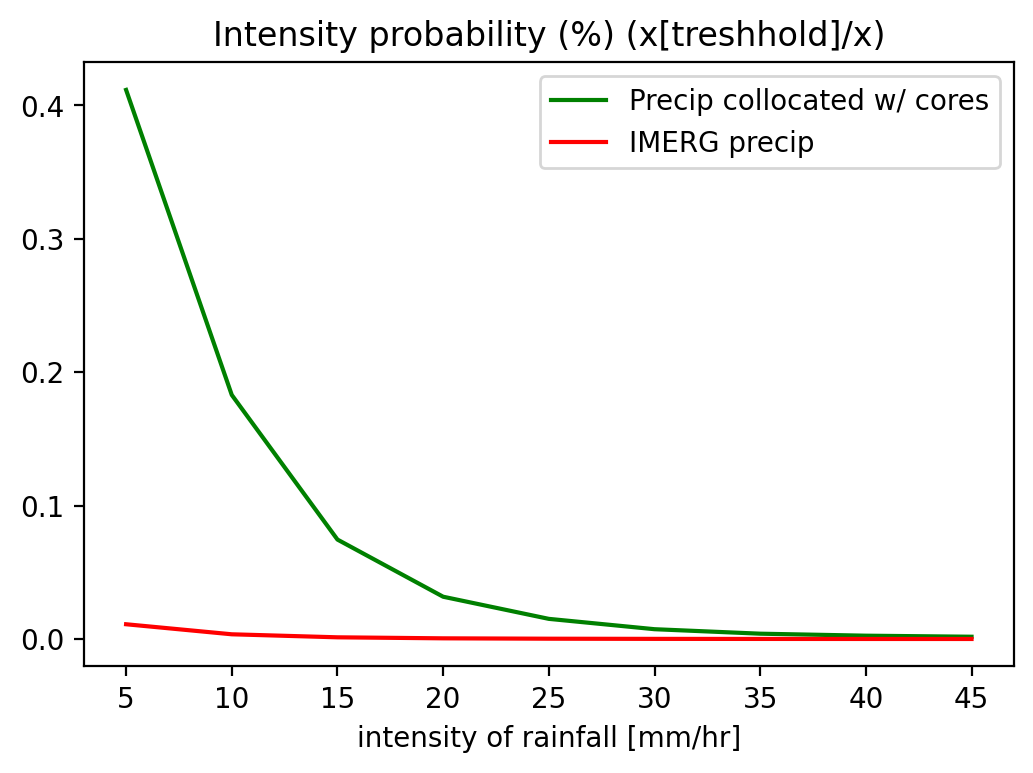

In [20]:
# fraction of rainfall pixels reached above intensity threshold to all rainfall pixels (collocated with cores)
f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

treached = []
treached1 = []

for intens in range(5,50,5):   
    cc = calc_treshReached(precip_collocated_w_cores, intens)
    cc1 = calc_treshReached(precip_1D, intens)
    treached.append(cc)
    treached1.append(cc1)

ax.plot(range(5,50,5), treached,color='green',label='Precip collocated w/ cores')
ax.plot(range(5,50,5), treached1,color='red',label='IMERG precip')

ax.set_title("Intensity probability (%) (x[treshhold]/x)")
plt.xlabel('intensity of rainfall [mm/hr]')
plt.legend()

Text(0.5, 0, 'intensity of rainfall [mm/hr]')

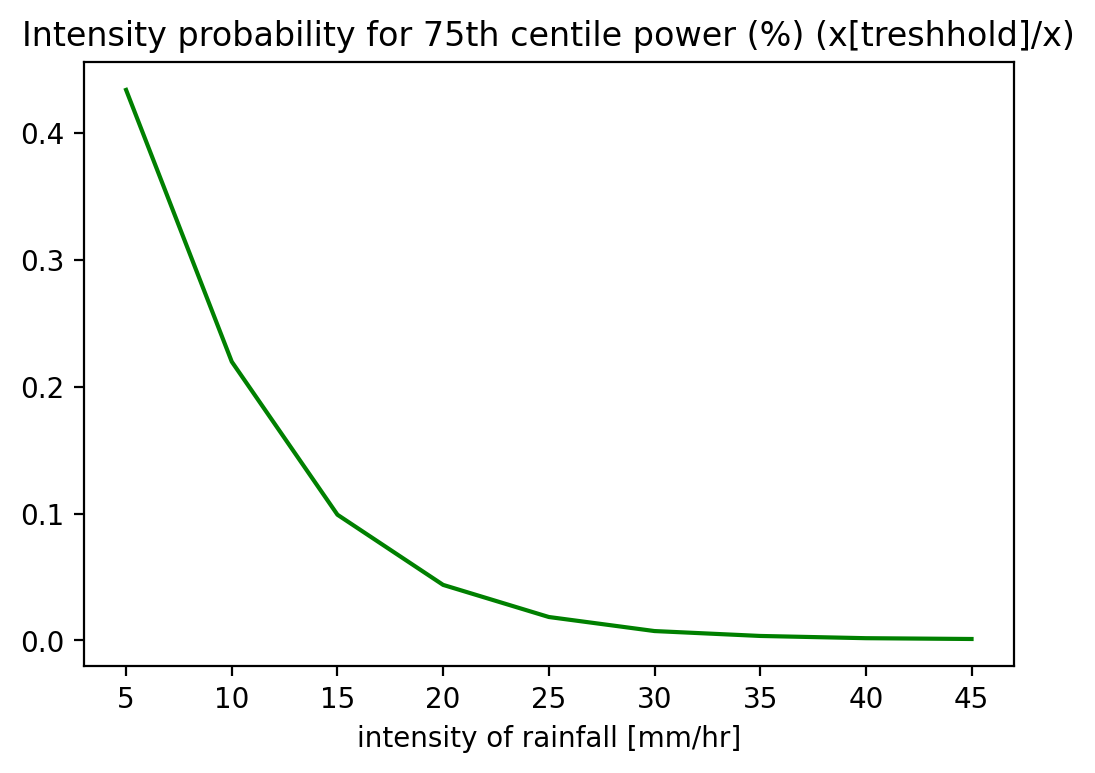

In [21]:
# plot frequency of caught pixels with rainfall above a threshold for regions with wavelet power above a given 
# percentile
f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

treached = []
for intens in range(5,50,5):   
    cc = percentile(precip_collocated_w_cores, cores_1D[cores_ind_gt_0], intens, 75)
    treached.append(cc)
    #plotdic.append((treached,dat[1]))
#for pp in plotdic:    
#ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.plot(range(5,50,5), treached,color='green')
ax.set_title("Intensity probability for 75th centile power (%) (x[treshhold]/x)")
plt.xlabel('intensity of rainfall [mm/hr]')
#ax.ylabel('fraction of rainfall pixels caught above intensity threshold that have >= 75th percentile wavelet power')
#plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_75p_wpower.jpg')

Text(0.5, 0, 'intensity of rainfall [mm/hr]')

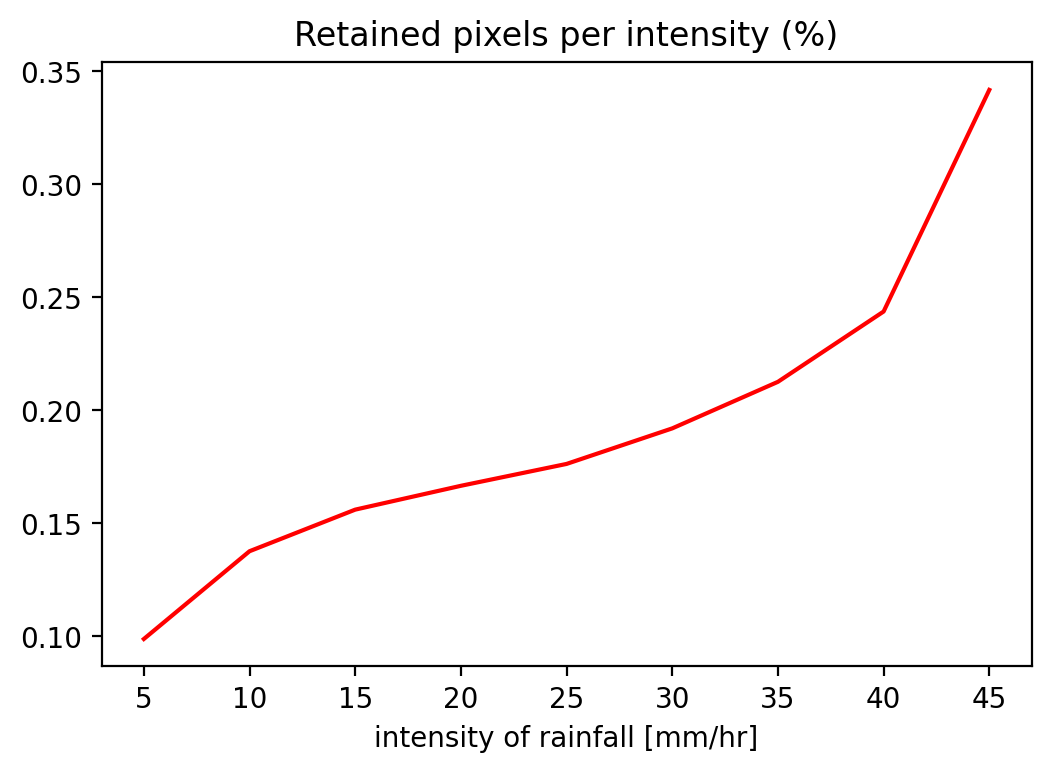

In [22]:
# fraction of rainfall pixels caught above intensity threshold to all caught rainfall pixels
f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

tcaught = []
for intens in range(5,50,5):   
    cc = calc_treshcaught(precip_collocated_w_cores, precip_1D, intens)
    tcaught.append(cc)

ax.plot(range(5,50,5), tcaught,color='red')
ax.set_title("Retained pixels per intensity (%)")
plt.xlabel('intensity of rainfall [mm/hr]')
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'_missedCases_southernAfricaDomain.jpg')   

In [23]:
# read cores daily data
#core_filename = '/prj/Africa_cloud/ch9_wavelet/2010/06/201006081045.nc'
#core_filename = '/prj/Africa_cloud/ch9_wavelet/2010/',month,'/201006081045.nc'
#core_data = nc.Dataset(core_filename,'r')
#print(core_data)
#cores_temp = np.array(core_data.variables['cores'])
#cores = np.array(core_data.variables['cores'])
#time = core_data.variables['time'][:]

#cores = cores.append(cores_temp)
# make a lat x lon x time dataset for monthly cores
#global_attributes = core_data.__dict__


# read precip data
#precip_filename = '/prj/global_water/MCS_Feng/global_v2/2d_fields/'
#precip_data = nc.Dataset(precip_filename,'r')

# visualize core data at inherent grid/resol
#plt.figure(figsize=(10,6))
#plt.contourf(X,Y,np.max(cores,axis=2),cmap='jet')
#plt.colorbar(label='power')
#plt.title(cores.time)
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.show()

# visualize regridded data
# plt.figure(figsize=(10,6))
#plt.contourf(X_new,Y_new,A,cmap='jet')
#plt.colorbar(label='power')
#plt.title(cores.time)
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.show()

In [24]:
# replace with precip data grid - bring coarse precip data (0.1) to fine core grid (0.04)
#new_lat = np.linspace(min(lat),max(lat),2000)#(lat[2]-lat[1])*2)
#new_lon = np.linspace(min(lon),max(lon),1900)#(lat[2]-lat[1])*2)
#X_new, Y_new = np.meshgrid(new_lon,new_lat)
#A = regrid_irregular_quick(lat_p,lon_p,lon,lat,cores_temp)
#regidded_precip[:,:,l] = A    

In [25]:
#df = pd.DataFrame()
# convert to datetime using pd.to_datetime
#df['date'] = pd.to_datetime(df['date'])
#da = xr.DataArray(data=cores,coords={"lat":(["x","y"],lat),
 #                                    "lon":(["x","y"],lon),
  #                                   "day":str(time_core)},
   #                                 dims=["x","y","day"])
